In [1]:
import sys
sys.path.append('../src')
sys.path.append('/Users/mahs128/Repos/CONCERTO')
from concerto.helpers.load_model_from_git import load_model_from_git
from eflux2 import EFlux2
import cobra
import pandas as pd
import numpy as np
import gurobipy
import os

In [4]:
os.getcwd()

'/Users/mahs128/Repos/syn_bmca/data'

## Load in inputs

### Read in enzyme data

In [95]:
enzyme_fname = "processed_data/reduced_enzyme.csv"
enzyme_df = pd.read_csv(enzyme_fname, index_col=0)
enzyme_df.head()

,Se_axen_d4_1,Se_axen_d4_2,Se_axen_d4_3,Se_axen_d6_1,Se_axen_d6_2,Se_axen_d6_3,Se_axen_d8_1,Se_axen_d8_2,Se_axen_d8_3
Reaction_ID,,,,,,,,,
DTMPK,1810,2030,1568,2020,1758,1736,946,1376,1598
ACOATA,4691,5294,3826,4813,4716,4054,1790,3524,3105
3HAD160,1636,1826,1332,1591,1476,999,711,1132,1436
RNDR3,28195,26841,22287,19726,17817,15050,12523,10904,9458
G5SD,20578,23123,19829,25519,20047,20535,12402,16955,19772


### Read in calculated flux data

In [96]:
all_fluxes_fname = "processed_data/calculated_metabolomic_abundance_rates.csv"
all_fluxes_df = pd.read_csv(all_fluxes_fname, index_col=0)
all_fluxes_df.head()

,Se_Rt_cc_d1_1,Se_Rt_cc_d1_2,Se_Rt_cc_d1_3,Se_Rt_cc_d2_1,Se_Rt_cc_d2_2,Se_Rt_cc_d2_3,Se_Rt_cc_d3_1,Se_Rt_cc_d3_2,Se_Rt_cc_d3_3,Se_Rt_cc_d4_1,...,Se_axen_d6_3,Se_axen_d7_1,Se_axen_d7_2,Se_axen_d7_3,Se_axen_d8_1,Se_axen_d8_2,Se_axen_d8_3,Se_axen_d9_1,Se_axen_d9_2,Se_axen_d9_3
Sample,,,,,,,,,,,,,,,,,,,,,
1)PDO,59582.0,2802.0,123090.0,51434.5,-24102.5,16509.5,-36135.5,-22385.0,-40031.5,-87508.5,...,-10967.5,-48686.5,8418.5,-19858.5,3339.0,-34320.5,12960.0,-11031.0,-65894.0,29284
2)BDO,11225.0,11965.0,21292.0,-650.0,-9510.0,3280.0,-12395.5,-7767.5,-9566.5,-12525.5,...,-4467.5,-14294.0,-4001.5,-1908.5,-2335.5,-37703.0,-1212.0,10395.0,-73752.0,-18138
3)2-HPY,173018.0,-35629.0,44975.0,53279.5,-58522.5,-18638.0,-51652.0,-43705.0,-50940.5,-4385.0,...,23249.5,22400.0,10544.5,5813.5,2793.5,-19815.5,41404.0,-60282.0,-107537.0,56971
4)HCAFFA,13902.0,-3282.0,2259.0,2619.0,-4486.0,-297.0,-8773.5,-2972.0,-3349.0,-2602.5,...,-843.5,-752.5,287.5,168.0,937.5,-1003.0,521.5,524.0,-3628.0,-224
5)m-HBA,24094.0,-2689.0,5573.0,-2112.0,-3868.0,2909.0,-23595.0,-2896.0,-1788.0,-13480.0,...,444.5,2359.5,-694.5,355.5,-437.0,-1084.5,-930.0,-5584.0,-708.0,718


In [97]:
fluxes_fname = "processed_data/cleaned_metabolomic_abundance_rates.csv"
fluxes_df = pd.read_csv(fluxes_fname, index_col=0)
fluxes_df.head()

,Se_axen_d4_1,Se_axen_d4_2,Se_axen_d4_3,Se_axen_d6_1,Se_axen_d6_2,Se_axen_d6_3,Se_axen_d8_1,Se_axen_d8_2,Se_axen_d8_3
Sample,,,,,,,,,
13ppd,-29836.5,-61719.5,12502.0,20379.0,31300.5,-10967.5,3339.0,-34320.5,12960.0
3hbz,-2978.0,-1145.0,-113.5,571.5,219.0,444.5,-437.0,-1084.5,-930.0
4hbz,-2529.5,1568.5,-1020.5,1889.5,-1916.0,810.0,-2246.5,818.0,1859.5
aso4,-4807.5,-3176.0,275.0,-795.0,-1199.0,-3490.0,1443.0,-2645.5,4379.5
bz,-83691.0,-34668.5,-18102.5,-13110.5,-25685.0,-52963.5,15482.5,-2626.0,21771.0


### Load SBML model

In [98]:
# syn_model = load_model_from_git('Synechococcus')
syn_model = cobra.io.read_sbml_model('../models/iJB785_no_zero_flux_flipped.xml')

## Prepare data by scaling/normalizing wrt reference strain

In [99]:
ref_strain = "Se_axen_d8_3"

In [100]:
# Normalize transcriptomics data with respect to reference strain column
normalized_enzyme_df = enzyme_df.div(enzyme_df[ref_strain], axis=0)
normalized_enzyme_df.head()

,Se_axen_d4_1,Se_axen_d4_2,Se_axen_d4_3,Se_axen_d6_1,Se_axen_d6_2,Se_axen_d6_3,Se_axen_d8_1,Se_axen_d8_2,Se_axen_d8_3
Reaction_ID,,,,,,,,,
DTMPK,1.132666,1.270338,0.981227,1.264080,1.100125,1.086358,0.591990,0.861076,1.0
ACOATA,1.510789,1.704992,1.232206,1.550081,1.518841,1.305636,0.576490,1.134944,1.0
3HAD160,1.139276,1.271588,0.927577,1.107939,1.027855,0.695682,0.495125,0.788301,1.0
RNDR3,2.981074,2.837915,2.356418,2.085642,1.883802,1.591246,1.324064,1.152886,1.0
G5SD,1.040765,1.169482,1.002883,1.290664,1.013909,1.038590,0.627251,0.857526,1.0


In [101]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Time points for data
time = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9])

# Concentration data
all_metab_df_fname = "processed_data/metabolomics.csv"
all_metab_df = pd.read_csv(all_metab_df_fname, index_col=0, header=0)
all_metab_df.head()



,Se_Rt_cc_d1_1,Se_Rt_cc_d1_2,Se_Rt_cc_d1_3,Se_Rt_cc_d2_1,Se_Rt_cc_d2_2,Se_Rt_cc_d2_3,Se_Rt_cc_d3_1,Se_Rt_cc_d3_2,Se_Rt_cc_d3_3,Se_Rt_cc_d4_1,...,Se_axen_d6_3,Se_axen_d7_1,Se_axen_d7_2,Se_axen_d7_3,Se_axen_d8_1,Se_axen_d8_2,Se_axen_d8_3,Se_axen_d9_1,Se_axen_d9_2,Se_axen_d9_3
Sample,,,,,,,,,,,,,,,,,,,,,
1)PDO,537254,641368,541050,596836.0,644170.0,664140.0,640123,593163.0,574069.0,524565.0,...,644933,601864,666479.0,608580.0,619573.0,663732,605216,608542,597838.0,634500
2)BDO,68406,76317,78862,79631.0,88282.0,100154.0,67106,57297.0,85422.0,54840.0,...,130010,103274,113340.0,110479.0,88208.0,111686,126193,98603,37934.0,108055
3)2-HPY,348831,595523,534314,521849.0,559894.0,579289.0,455390,478478.0,497038.0,418545.0,...,644055,547957,653735.0,629845.0,613826.0,721641,655682,553544,614104.0,712653
4)HCAFFA,32860,25425,17270,46762.0,22143.0,19529.0,38098,16453.0,16676.0,29215.0,...,3534,3881,4632.0,2603.0,5232.0,6254,3870,5756,2626.0,3646
5)m-HBA,93751,47656,29530,117845.0,44967.0,35103.0,89527,39920.0,35348.0,70655.0,...,9837,16039,14814.0,13126.0,20749.0,13353,10548,15165,12645.0,11266


In [102]:
sucrose_idx = "42)SUCR"
axen_exp_columns = np.array([c for c in all_metab_df.columns if "axen" in c])
axen_exp_columns = axen_exp_columns.reshape(9, 3)
axen_exp_columns[:,0]

array(['Se_axen_d1_1', 'Se_axen_d2_1', 'Se_axen_d3_1', 'Se_axen_d4_1',
       'Se_axen_d5_1', 'Se_axen_d6_1', 'Se_axen_d7_1', 'Se_axen_d8_1',
       'Se_axen_d9_1'], dtype='<U12')

In [162]:
Rep_met_data = {}
Rep_flux_data = {}
for i in range(3):
    this_rep_cols = axen_exp_columns[:,i]
    Rep_met_data[i+1] = all_metab_df.loc[sucrose_idx, this_rep_cols]
    Rep_flux_data[i+1] = all_fluxes_df.loc[sucrose_idx, this_rep_cols]

Rep_met_data_3 = np.concatenate([Rep_met_data[1], Rep_met_data[2], Rep_met_data[3]])
Rep_flux_data_3 = np.concatenate([Rep_flux_data[1], Rep_flux_data[2], Rep_flux_data[3]])

print("--- Metabolomics ---")
display(Rep_met_data)
display(Rep_met_data_3)

print("--- Flux ---")
display(Rep_flux_data)
display(Rep_flux_data_3)


--- Metabolomics ---


{1: Se_axen_d1_1      2371906.0
 Se_axen_d2_1    108953597.0
 Se_axen_d3_1    202621460.0
 Se_axen_d4_1    216402623.0
 Se_axen_d5_1    202490722.0
 Se_axen_d6_1    209296716.0
 Se_axen_d7_1    207734404.0
 Se_axen_d8_1    226721805.0
 Se_axen_d9_1    231482702.0
 Name: 42)SUCR, dtype: float64,
 2: Se_axen_d1_2      2803151.0
 Se_axen_d2_2     79641028.0
 Se_axen_d3_2    196384448.0
 Se_axen_d4_2    186768919.0
 Se_axen_d5_2    217806224.0
 Se_axen_d6_2    248798568.0
 Se_axen_d7_2    220460447.0
 Se_axen_d8_2    246981451.0
 Se_axen_d9_2    210726201.0
 Name: 42)SUCR, dtype: float64,
 3: Se_axen_d1_3      5289566.0
 Se_axen_d2_3    114926451.0
 Se_axen_d3_3    180772384.0
 Se_axen_d4_3    200938562.0
 Se_axen_d5_3    219136280.0
 Se_axen_d6_3    207329930.0
 Se_axen_d7_3    186965633.0
 Se_axen_d8_3    222409804.0
 Se_axen_d9_3    254294421.0
 Name: 42)SUCR, dtype: float64}

array([2.37190600e+06, 1.08953597e+08, 2.02621460e+08, 2.16402623e+08,
       2.02490722e+08, 2.09296716e+08, 2.07734404e+08, 2.26721805e+08,
       2.31482702e+08, 2.80315100e+06, 7.96410280e+07, 1.96384448e+08,
       1.86768919e+08, 2.17806224e+08, 2.48798568e+08, 2.20460447e+08,
       2.46981451e+08, 2.10726201e+08, 5.28956600e+06, 1.14926451e+08,
       1.80772384e+08, 2.00938562e+08, 2.19136280e+08, 2.07329930e+08,
       1.86965633e+08, 2.22409804e+08, 2.54294421e+08])

--- Flux ---


{1: Se_axen_d1_1    106581691.0
 Se_axen_d2_1    100124777.0
 Se_axen_d3_1     53724513.0
 Se_axen_d4_1       -65369.0
 Se_axen_d5_1     -3552953.5
 Se_axen_d6_1      2621841.0
 Se_axen_d7_1      8712544.5
 Se_axen_d8_1     11874149.0
 Se_axen_d9_1      4760897.0
 Name: 42)SUCR, dtype: float64,
 2: Se_axen_d1_2    76837877.0
 Se_axen_d2_2    96790648.5
 Se_axen_d3_2    53563945.5
 Se_axen_d4_2    10710888.0
 Se_axen_d5_2    31014824.5
 Se_axen_d6_2     1327111.5
 Se_axen_d7_2     -908558.5
 Se_axen_d8_2    -4867123.0
 Se_axen_d9_2   -36255250.0
 Name: 42)SUCR, dtype: float64,
 3: Se_axen_d1_3    109636885.0
 Se_axen_d2_3     87741409.0
 Se_axen_d3_3     43006055.5
 Se_axen_d4_3     19181948.0
 Se_axen_d5_3      3195684.0
 Se_axen_d6_3    -16085323.5
 Se_axen_d7_3      7539937.0
 Se_axen_d8_3     33664394.0
 Se_axen_d9_3     31884617.0
 Name: 42)SUCR, dtype: float64}

array([ 1.06581691e+08,  1.00124777e+08,  5.37245130e+07, -6.53690000e+04,
       -3.55295350e+06,  2.62184100e+06,  8.71254450e+06,  1.18741490e+07,
        4.76089700e+06,  7.68378770e+07,  9.67906485e+07,  5.35639455e+07,
        1.07108880e+07,  3.10148245e+07,  1.32711150e+06, -9.08558500e+05,
       -4.86712300e+06, -3.62552500e+07,  1.09636885e+08,  8.77414090e+07,
        4.30060555e+07,  1.91819480e+07,  3.19568400e+06, -1.60853235e+07,
        7.53993700e+06,  3.36643940e+07,  3.18846170e+07])

In [163]:
derivative_log_model(time, 5298932.70432621,  18417181.29218286, -18417180.3480416)

array([1.03365258e+14, 5.29892999e+07, 2.64946567e+07, 1.76631060e+07,
       1.32473301e+07, 1.05978643e+07, 8.83155375e+06, 7.56990331e+06,
       6.62366546e+06, 5.88770267e+06, 5.29893243e+06, 4.81721132e+06,
       4.41577706e+06, 4.07610192e+06, 3.78495179e+06, 3.53262168e+06,
       3.31183283e+06, 3.11701914e+06, 2.94385142e+06, 2.78891187e+06,
       2.64946628e+06, 2.52330123e+06, 2.40860572e+06, 2.30388373e+06,
       2.20788858e+06, 2.11957304e+06, 2.03805100e+06, 1.96256763e+06,
       1.89247593e+06, 1.82721814e+06, 1.76631087e+06, 1.70933310e+06,
       1.65591644e+06, 1.60573716e+06, 1.55850960e+06, 1.51398075e+06,
       1.47192573e+06, 1.43214395e+06, 1.39445596e+06, 1.35870068e+06,
       1.32473316e+06, 1.29242259e+06, 1.26165063e+06, 1.23230992e+06,
       1.20430287e+06, 1.17754059e+06, 1.15194188e+06, 1.12743248e+06,
       1.10394430e+06, 1.08141483e+06, 1.05978653e+06, 1.03900640e+06,
       1.01902551e+06, 9.99798614e+05, 9.81283825e+05, 9.63442301e+05,
      

[0 1 2 3 4 5 6 7 8 9 1 2 3 4 5 6 7 8 9 1 2 3 4 5 6 7 8 9]
28
28
[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7
 1.8 1.9 2.  2.1 2.2 2.3 2.4 2.5 2.6 2.7 2.8 2.9 3.  3.1 3.2 3.3 3.4 3.5
 3.6 3.7 3.8 3.9 4.  4.1 4.2 4.3 4.4 4.5 4.6 4.7 4.8 4.9 5.  5.1 5.2 5.3
 5.4 5.5 5.6 5.7 5.8 5.9 6.  6.1 6.2 6.3 6.4 6.5 6.6 6.7 6.8 6.9 7.  7.1
 7.2 7.3 7.4 7.5 7.6 7.7 7.8 7.9 8.  8.1 8.2 8.3 8.4 8.5 8.6 8.7 8.8 8.9
 9. ]
[8.71521940e+04 1.28708836e+05 1.90060411e+05 2.80611963e+05
 4.14208980e+05 6.11200980e+05 9.01425687e+05 1.32847954e+06
 1.95573229e+06 2.87459083e+06 4.21541134e+06 6.16097266e+06
 8.96113394e+06 1.29445612e+07 1.85185674e+07 2.61414814e+07
 3.62471025e+07 4.91074301e+07 6.46517487e+07 8.23176737e+07
 1.01051128e+08 1.19524366e+08 1.36496161e+08 1.51122739e+08
 1.63070749e+08 1.72434216e+08 1.79561114e+08 1.84891175e+08
 1.88850113e+08 1.91799468e+08 1.94023563e+08 1.95735423e+08
 1.97089689e+08 1.98196302e+08 1.99132329e+08 1.99951293e+08
 2.00690125e+08 

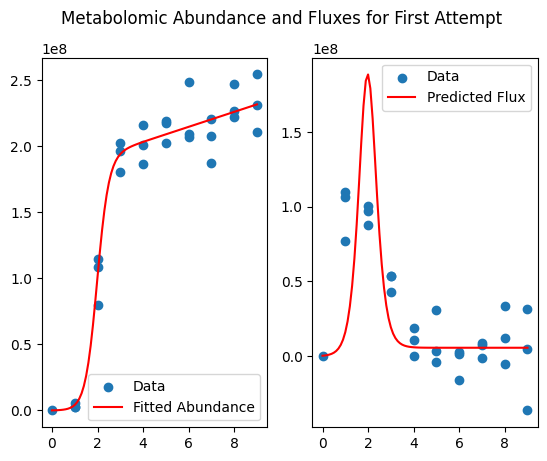

In [168]:
# First fit to all data to get initial guesses
time = np.arange(0,9.1,0.1)
fit_time = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9])
fit_time_3 = np.concatenate([[0], fit_time, fit_time, fit_time])
print(fit_time_3)

# Define customized logistic growth model with time-dependent carrying capacity
def modified_logistic_model(t, P0, r, K0, Kr):
    Kt = K0 + Kr * t
    return Kt / (1 + ((Kt - P0) / P0) * np.exp(-r * t))
def derivative_modified_logistic_model(t, P0, r, K0, Kr):
    dt = 1e-6  # A small change in time to compute the numerical derivative
    C1 = modified_logistic_model(t + dt, P0, r, K0, Kr)
    C0 = modified_logistic_model(t, P0, r, K0, Kr)
    dCdt = (C1 - C0) / dt
    return dCdt

# Use averaged data for initial guesses
Rep_met_data_3 = np.concatenate([Rep_met_data[1], Rep_met_data[2], Rep_met_data[3]])
Rep_flux_data_3 = np.concatenate([Rep_flux_data[1], Rep_flux_data[2], Rep_flux_data[3]])

Rep_met_data_avg = np.sum([Rep_met_data[1], Rep_met_data[2], Rep_met_data[3]], axis=0) / 3.0
Rep_met_data_3 = np.concatenate([[0], Rep_met_data_3])
Rep_flux_data_3 = np.concatenate([[0], Rep_flux_data_3])

# Use fitted parameters from the simple logistic regression model as initial guesses for the modified logistic regression model
P0_guess = 2.67875361e+05 #np.mean(Rep_met_data_avg[0]) # Initial concentration
r_guess = 3.34459208e+00 #np.max(np.diff(Rep_met_data_avg) / np.diff(fit_time)) # Growth rate r guess
K0_guess = 2.14999162e+08 # np.mean(Rep_met_data_avg[-3:])  # Average of the last five data points for Initial carrying capacity
Kr_guess = 0 #(Rep_met_data_avg[-1] - Rep_met_data_avg[0]) / (fit_time[-1] - fit_time[0])  # Linear approximation for Rate of increase of carrying capacity Kr
initial_guesses = [P0_guess, r_guess, K0_guess, Kr_guess]



# Fit the model to the data
print(len(fit_time_3))
print(len(Rep_met_data_3))
first_params, covariance = curve_fit(modified_logistic_model, fit_time_3, Rep_met_data_3, p0=initial_guesses, maxfev=10000)
P0, r, K0, Kr = first_params

# Generate fitted values
fitted_data = modified_logistic_model(time, P0, r, K0, Kr)

# Calculate the derivative at a specific time using the analytical method
fitted_derivative = derivative_modified_logistic_model(time, P0, r, K0, Kr)

print(time)
print(fitted_data)
print(fitted_derivative)

# Plot the original data and the fitted curve
print(f"First attempt parameters: {first_params}")

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle(f'Metabolomic Abundance and Fluxes for First Attempt')

ax1.scatter(fit_time_3, Rep_met_data_3, label='Data')
ax1.plot(time, fitted_data, label='Fitted Abundance', color='red')
# ax1.xlabel('Time')
# ax1.ylabel('Abundance')
# ax1.title('Logistic Growth Model Fitted to Abundance')
ax1.legend()

ax2.scatter(fit_time_3, Rep_flux_data_3, label='Data')
ax2.plot(time, fitted_derivative, label='Predicted Flux', color='red')
# ax2.xlabel('Time')
# ax2.ylabel('Flux')
# ax2.title('Derivative of Logistic Growth Model Fitted to Abundance')
ax2.legend()

plt.show()

[1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7 1.8 1.9 2.  2.1 2.2 2.3 2.4 2.5 2.6 2.7
 2.8 2.9 3.  3.1 3.2 3.3 3.4 3.5 3.6 3.7 3.8 3.9 4.  4.1 4.2 4.3 4.4 4.5
 4.6 4.7 4.8 4.9 5.  5.1 5.2 5.3 5.4 5.5 5.6 5.7 5.8 5.9 6.  6.1 6.2 6.3
 6.4 6.5 6.6 6.7 6.8 6.9 7.  7.1 7.2 7.3 7.4 7.5 7.6 7.7 7.8 7.9 8.  8.1
 8.2 8.3 8.4 8.5 8.6 8.7 8.8 8.9 9. ]
Predicted Derivative values: [6.88176419e+06 1.14622238e+07 1.89737492e+07 3.10889993e+07
 5.00988121e+07 7.86044337e+07 1.18297156e+08 1.67294330e+08
 2.16833030e+08 2.51290256e+08 2.56108080e+08 2.29221538e+08
 1.82848073e+08 1.33310424e+08 9.13375804e+07 6.03210516e+07
 3.92417820e+07 2.56316355e+07 1.71135195e+07 1.18816577e+07
 8.70434830e+06 6.78779641e+06 5.63640916e+06 4.94637617e+06
 4.53343415e+06 4.28652817e+06 4.13897502e+06 4.05082354e+06
 3.99816996e+06 3.96672320e+06 3.94794336e+06 3.93672854e+06
 3.93003169e+06 3.92603278e+06 3.92364481e+06 3.92221895e+06
 3.92136753e+06 3.92085916e+06 3.92055556e+06 3.92037436e+06
 3.92026612e+06 3.92020154e+06 

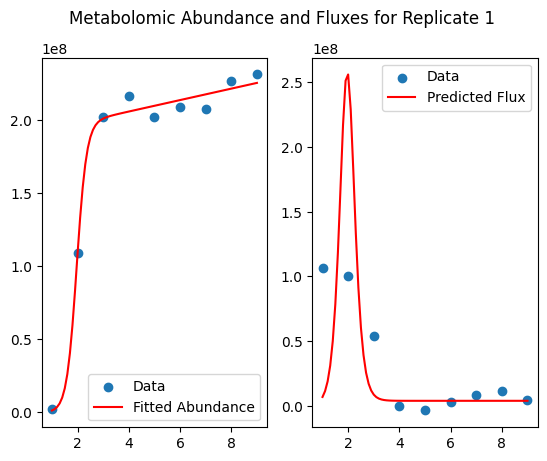

Predicted Derivative values: [1.41029007e+07 1.95202678e+07 2.68368863e+07 3.65562761e+07
 4.91744779e+07 6.50446952e+07 8.41514739e+07 1.05808795e+08
 1.28376418e+08 1.49195530e+08 1.64983194e+08 1.72750804e+08
 1.70915611e+08 1.59968013e+08 1.42245212e+08 1.20973364e+08
 9.91910838e+07 7.90767238e+07 6.17985211e+07 4.77073337e+07
 3.66385638e+07 2.81766886e+07 2.18331585e+07 1.71441968e+07
 1.37131236e+07 1.12206169e+07 9.41929513e+06 8.12230361e+06
 7.19090924e+06 6.52332011e+06 6.04546240e+06 5.70374364e+06
 5.45954719e+06 5.28512770e+06 5.16059124e+06 5.07169428e+06
 5.00824946e+06 4.96297559e+06 4.93067157e+06 4.90762365e+06
 4.89118049e+06 4.87945002e+06 4.87108165e+06 4.86511207e+06
 4.86085367e+06 4.85781607e+06 4.85564932e+06 4.85410362e+06
 4.85300121e+06 4.85221481e+06 4.85165393e+06 4.85125381e+06
 4.85096845e+06 4.85076493e+06 4.85061979e+06 4.85051620e+06
 4.85044235e+06 4.85038966e+06 4.85035214e+06 4.85032529e+06
 4.85030624e+06 4.85029256e+06 4.85028291e+06 4.85027596

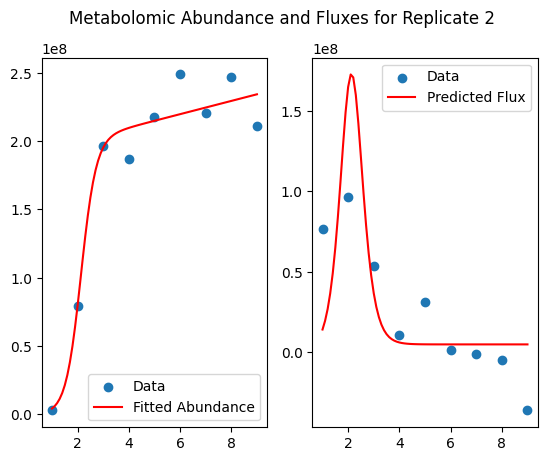

Predicted Derivative values: [2.40694317e+07 3.41932032e+07 4.78504350e+07 6.55778670e+07
 8.73540799e+07 1.12072422e+08 1.37082018e+08 1.58256502e+08
 1.71041006e+08 1.72307069e+08 1.61911120e+08 1.42740946e+08
 1.19224459e+08 9.54851204e+07 7.42576294e+07 5.67670640e+07
 4.31479834e+07 3.29521587e+07 2.55245346e+07 2.02147172e+07
 1.64679837e+07 1.38477997e+07 1.20267011e+07 1.07663377e+07
 9.89658871e+06 9.29759446e+06 8.88563740e+06 8.60258505e+06
 8.40823105e+06 8.27484244e+06 8.18332556e+06 8.12055120e+06
 8.07749975e+06 8.04797822e+06 8.02773654e+06 8.01385868e+06
 8.00434461e+06 7.99782243e+06 7.99335161e+06 7.99028692e+06
 7.98818627e+06 7.98674652e+06 7.98575968e+06 7.98508337e+06
 7.98461992e+06 7.98430228e+06 7.98408455e+06 7.98393536e+06
 7.98383316e+06 7.98376313e+06 7.98371509e+06 7.98368222e+06
 7.98365968e+06 7.98364422e+06 7.98363364e+06 7.98362643e+06
 7.98362145e+06 7.98361802e+06 7.98361573e+06 7.98361409e+06
 7.98361301e+06 7.98361230e+06 7.98361176e+06 7.98361146

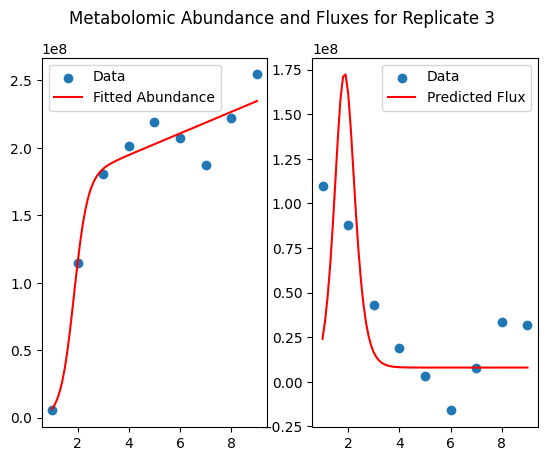

In [169]:
# Define a model that ensures a monotonically increasing curve
time = np.arange(1,9.1,0.1)
print(time)

fit_time = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9])


# Fit the model to the data

# Defne an polynomial model
def poly_model(t, a, b, c, d, e, f):
    return a*(t**5) + b*(t**4) + c*(t**3) + d*(t**2) + e*t + f
def derivative_poly_model(t, a, b, c, d, e):
    return 5*a*(t**4) + 4*b*(t**3) + 3*c*(t**2) + 2*d*t + e


# Defne an exponential growth model
def exp_model(t, a, b, c, d):
    return a * np.exp(b * t + c) + d
def derivative_exp_model(t, a, b, c):
    return (a * b) * np.exp(b * t + c)

# Define an logarithmic growth model
def log_model(t, a, b, c, d):
    return a * np.log(b * t + c) + d
def derivative_log_model(t, a, b, c):
    return (a * b) / (b * t + c)

# Define a logistic growth model
def logistic_model(t, K, P0, r):
    return K / (1 + ((K - P0) / P0) * np.exp(-r * t))
def derivative_logistic_model_analytical(t, K, P0, r):
    exp_rt = np.exp(-r * t)
    return (K * r * exp_rt * ((K - P0) / P0)) / ((1 + ((K - P0) / P0) * exp_rt) ** 2)

# Define customized logistic growth model with time-dependent carrying capacity
def modified_logistic_model(t, P0, r, K0, Kr):
    Kt = K0 + Kr * t
    return Kt / (1 + ((Kt - P0) / P0) * np.exp(-r * t))
def derivative_modified_logistic_model(t, P0, r, K0, Kr):
    dt = 1e-6  # A small change in time to compute the numerical derivative
    C1 = modified_logistic_model(t + dt, P0, r, K0, Kr)
    C0 = modified_logistic_model(t, P0, r, K0, Kr)
    dCdt = (C1 - C0) / dt
    return dCdt

# # Calculate the derivative at a specific time using the analytical method
# rate_of_change_analytical = derivative_logistic_model_analytical(t, K, P0, r)


params = {}

for i in range(1,4):
    ### Initial guess for the parameters
    # # Modified logistic growth model
    # P0_guess = Rep_met_data[i][0] # Initial concentration
    # r_guess = np.max(np.diff(Rep_met_data[i]) / np.diff(fit_time)) # Growth rate r guess
    # K0_guess = np.mean(Rep_met_data[i][-5:])  # Average of the last five data points for Initial carrying capacity
    # Kr_guess = (Rep_met_data[i][-1] - Rep_met_data[i][0]) / (fit_time[-1] - fit_time[0])  # Linear approximation for Rate of increase of carrying capacity Kr
    # initial_guesses = [P0_guess, r_guess, K0_guess, Kr_guess]
    initial_guesses = first_params # see previous cell
    
    # # Simple logistic growth model
    # K_guess = max(Rep_met_data[i])
    # P0_guess = min(Rep_met_data[i])
    # r_guess = 1
    # initial_guess = [K_guess, P0_guess, r_guess]



    ###

    # # Fit the model to the data
    params[i], covariance = curve_fit(modified_logistic_model, fit_time, Rep_met_data[i], p0=initial_guesses, maxfev=10000)
    # params[i], covariance = curve_fit(logistic_model, fit_time, Rep_met_data[i], p0=initial_guess, maxfev=10000)
    # params[i], covariance = curve_fit(poly_model, fit_time, Rep_met_data[i], maxfev=10000)
    # params[i], covariance = curve_fit(exp_model, fit_time, Rep_met_data[i], maxfev=10000)

    # # Extract the parameters
    P0, r, K0, Kr = params[i]
    # K, P0, r = params[i]
    # a, b, c, d = params[i]
    # a, b, c, d, e, f = params[i]

    # # Generate fitted values
    fitted_data = modified_logistic_model(time, P0, r, K0, Kr)
    # fitted_data = logistic_model(time, K, P0, r)
    # fitted_data = poly_model(time, a, b, c, d, e, f)
    # fitted_data = exp_model(time, a, b, c, d)

    # # Calculate the derivative at a specific time using the analytical method
    fitted_derivative = derivative_modified_logistic_model(time, P0, r, K0, Kr)
    # fitted_derivative = derivative_logistic_model_analytical(time, K, P0, r)
    # fitted_derivative = derivative_poly_model(time, a, b, c, d, e)
    # fitted_derivative = derivative_exp_model(time, a, b, c)
    print(f"Predicted Derivative values: {fitted_derivative}")
    



# # Define a hyperbolic tangent model
# def tanh_model(t, a, b, c, d):
#     return a * np.tanh(b * t + c) + d

# # Initial guess for the parameters
# initial_guess = [1, 1, 1, 1]

# # Fit the model to the data
# params, covariance = curve_fit(tanh_model, time, Rep_data[1], p0=initial_guess, maxfev=10000)

# # Extract the parameters
# a, b, c, d = params

# # Generate fitted values
# fitted_data = tanh_model(time, a, b, c, d)




    # Plot the original data and the fitted curve
    print(f"Rep #{i} parameters: {params[i]}")

    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle(f'Metabolomic Abundance and Fluxes for Replicate {i}')
    
    ax1.scatter(fit_time, Rep_met_data[i], label='Data')
    ax1.plot(time, fitted_data, label='Fitted Abundance', color='red')
    # ax1.xlabel('Time')
    # ax1.ylabel('Abundance')
    # ax1.title('Logistic Growth Model Fitted to Abundance')
    ax1.legend()

    ax2.scatter(fit_time, Rep_flux_data[i], label='Data')
    ax2.plot(time, fitted_derivative, label='Predicted Flux', color='red')
    # ax2.xlabel('Time')
    # ax2.ylabel('Flux')
    # ax2.title('Derivative of Logistic Growth Model Fitted to Abundance')
    ax2.legend()

    plt.show()

In [20]:
# Normalize flux data with respect to reference strain column
normalized_fluxes_df = fluxes_df.div(fluxes_df[ref_strain], axis=0)
normalized_fluxes_df.head()

,Se_axen_d4_1,Se_axen_d4_2,Se_axen_d4_3,Se_axen_d6_1,Se_axen_d6_2,Se_axen_d6_3,Se_axen_d8_1,Se_axen_d8_2,Se_axen_d8_3
Sample,,,,,,,,,
13ppd,-2.302199,-4.762307,0.964660,1.572454,2.415162,-0.846258,0.257639,-2.648187,1.0
3hbz,3.202151,1.231183,0.122043,-0.614516,-0.235484,-0.477957,0.469892,1.166129,1.0
4hbz,-1.360312,0.843506,-0.548803,1.016133,-1.030385,0.435601,-1.208120,0.439903,1.0
aso4,-1.097728,-0.725197,0.062793,-0.181528,-0.273776,-0.796895,0.329490,-0.604064,1.0
bz,-3.844150,-1.592417,-0.831496,-0.602200,-1.179780,-2.432755,0.711152,-0.120619,1.0


In [25]:
normalized_fluxes_df.index

Index(['13ppd', '3hbz', '4hbz', 'aso4', 'bz', '34dhcinm', 'fru', 'glc__D',
       'rib__D', 'xylt', 'etham', 'glyclt', 'hqn', 'lac__D', 'mal__L', 'malt',
       'inost', 'oxa', 'hdca', 'pi', 'quin', 'ocdca', 'sucr', 'thym', 'ala__L',
       'val__L', 'leu__L', 'ile__L', 'pro__L', 'glyc', 'met__L', 'ser__L',
       'thr__L', 'phe__L', 'akg', 'glu__L', 'asn__L', 'lys__L', 'gln__L',
       'his__L', 'tyr__L', 'trp__L'],
      dtype='object', name='Sample')

## Run FBA constrained only on sucrose flux

In [44]:
# # Identify candiates for target intake metabolite and corresponding reaction
# intake_target_met = None #

# # Identify candiates for target secretion metabolite and corresponding reaction
# secrete_target_met = ["sucr"] # BiGG ID for sucrose
# secrete_target_rxn = [f"EX_{r}_e" for r in secrete_target_met]

# Declare list of metabolites to constrain fluxes on 
external_mets = ["sucr"]

# Create list of reaction IDs recognizeable by  to constrain fluxes on
external_rxns = [f"EX_{r}_e" for r in external_mets]

# List of replicates/strains/lines included in data
replicate_list = normalized_enzyme_df.columns

# Use teh Gurobi solver in the model
syn_model.solver = 'gurobi'

display(normalized_fluxes_df.loc[external_mets])


,Se_axen_d4_1,Se_axen_d4_2,Se_axen_d4_3,Se_axen_d6_1,Se_axen_d6_2,Se_axen_d6_3,Se_axen_d8_1,Se_axen_d8_2,Se_axen_d8_3
Sample,,,,,,,,,
sucr,-0.001942,0.318167,0.569799,0.077882,0.039422,-0.477814,0.352721,-0.144578,1.0


In [ ]:
# TODO: generalize this as a function with various options for intake candidate availability, or using growth rates instead

def run_fba_on_condition(model, external_fluxes: dict, enzyme_activity: dict) -> dict:
    """Run FBA after constraining a cobra model on provided external flux and/or enzyme activity."""
    

    return flux_dict



fluxes = {}
for rep in replicate_list:
    with syn_model:
        # Collect fluxes for this replicate/strain/line
        # TODO: generalize external_mets
        constraint_fluxes = normalized_fluxes_df.loc[external_mets, rep]
        
        # Update model reaction bounds with experimentally calculated rate
        
        if constraint_fluxes:
            for rxn in 
            getattr(syn_model.reactions, secrete_target_rxn).lower_bound = secrete_target
        try:
            print(rep)
            fluxes[rep] = EFlux2(syn_model, normalized_transcriptomics_df[rep])
        except TypeError:
            print(f"Replicate {rep} with uptake of {intake_target_met} and secretion of {secrete_target_met} is infeasible")
fluxes[rep]